# Real Estate Price Prediction using PySpark
This notebook performs data wrangling, inference, and machine learning using Apache Spark.
All computations are handled in PySpark, while visualizations are done in Matplotlib/Seaborn.

A machine learning model was developed to predict home prices based on number of bedrooms, bathrooms, square footage, and zip code. The goal was to simulate a real estate price estimator that returns an expected price when given user-defined specifications.

The data was cleaned, transformed, and key features were log-transformed to reduce skew. High-cardinality categorical data (zip code) was encoded for model compatibility. Gradient Boosted Trees were used due to their strength in handling non-linear relationships and feature interactions.

Load Libraries and Load and Examine Dataset

In [ ]:
import time
start_time = time.time()

In [ ]:
# Standard Libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util
import subprocess
from scipy.stats import ks_2samp

# PySpark Setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, mean, log1p, substring
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, log1p
from pyspark.ml.functions import vector_to_array

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder.appName("RealEstatePricePrediction").config("spark.sql.execution.arrow.enabled", "true").getOrCreate()


In [ ]:
# Load dataset from the current directory
file_path = "realtor-data.csv"

# Check if the file exists before loading (optional but safe)
import os
if not os.path.exists(file_path):
    raise FileNotFoundError(f"❌ '{file_path}' not found in current directory.")

# Load the dataset using Spark
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()
df.show(5)


root
 |-- brokered_by: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bed: integer (nullable = true)
 |-- bath: integer (nullable = true)
 |-- acre_lot: double (nullable = true)
 |-- street: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- house_size: integer (nullable = true)
 |-- prev_sold_date: string (nullable = true)

+-----------+--------+--------+---+----+--------+-------+----------+-----------+--------+----------+--------------+
|brokered_by|  status|   price|bed|bath|acre_lot| street|      city|      state|zip_code|house_size|prev_sold_date|
+-----------+--------+--------+---+----+--------+-------+----------+-----------+--------+----------+--------------+
|     103378|for_sale|105000.0|  3|   2|    0.12|1962661|  Adjuntas|Puerto Rico|     601|       920|          NULL|
|      52707|for_sale| 80000.0|  4|   2|    0.08|1902874

In [ ]:
#Get row and column count
print(f"✅ Dataset Shape: {df.count()}, {len(df.columns)}")

✅ Dataset Shape: 1048575, 12


In [ ]:
# Basic descriptive statistics for numerical columns
print("📊 Basic Descriptive Statistics:\n")
df.describe().show()


📊 Basic Descriptive Statistics:

+-------+------------------+--------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------+-----------------+------------------+--------------+
|summary|       brokered_by|        status|             price|               bed|              bath|          acre_lot|            street|                city|  state|         zip_code|        house_size|prev_sold_date|
+-------+------------------+--------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------+-----------------+------------------+--------------+
|  count|           1047537|       1048575|           1047485|            738569|            723607|            870247|           1041799|             1047715|1048568|          1048416|            683689|        497886|
|   mean|51877.266208258035|          NULL| 477497.8739319991| 3.309545892123823|2.5361

Clean Dataset

In [ ]:
# Get a list of unique state names in the dataset
unique_states = df.select("state").distinct().show()

# Display the unique state values
print("Unique States in Dataset:")
print(unique_states)


+--------------------+
|               state|
+--------------------+
|        Pennsylvania|
|         Connecticut|
|             Vermont|
|         Puerto Rico|
|      Virgin Islands|
|            Delaware|
|       West Virginia|
|        Rhode Island|
|             Georgia|
|            Virginia|
|             Wyoming|
|          New Jersey|
|       Massachusetts|
|       New Hampshire|
|           Tennessee|
|      South Carolina|
|            New York|
|               Maine|
|                Ohio|
|District of Columbia|
+--------------------+
only showing top 20 rows

Unique States in Dataset:
None


In [ ]:
# Define non-US territories to remove (keeping DC)
non_us_territories = ["Puerto Rico", "Virgin Islands", "New Brunswick"]

# Remove rows with non-US territories
df_cleaned = df[~df["state"].isin(non_us_territories)]

# Show unique states after filtering
print("✅ Unique states remaining after filtering:")
print(df_cleaned.select("state").distinct().show())

✅ Unique states remaining after filtering:
+--------------------+
|               state|
+--------------------+
|        Pennsylvania|
|         Connecticut|
|             Vermont|
|            Delaware|
|       West Virginia|
|        Rhode Island|
|             Georgia|
|            Virginia|
|             Wyoming|
|          New Jersey|
|       Massachusetts|
|       New Hampshire|
|           Tennessee|
|      South Carolina|
|            New York|
|               Maine|
|                Ohio|
|District of Columbia|
|            Missouri|
|      North Carolina|
+--------------------+
only showing top 20 rows

None


In [ ]:
# Check current dataset size
print(f"✅ Current dataset shape: {(df_cleaned.count(), len(df.columns))}")
from pyspark.sql.functions import col
# Check for NULL
df_cleaned.filter(
    col("bed").isNull() & col("bath").isNull() & col("house_size").isNull()
).count()


✅ Current dataset shape: (1045153, 12)


299228

In [ ]:
from pyspark.sql.functions import col, when, count, lower, lit
import pandas as pd

# Total row count
total_rows = df_cleaned.count()

# Create list of expressions to count missing or "NULL" string values
missing_exprs = [
    (count(when(col(c).isNull() | (lower(col(c)) == "null"), c)) / total_rows * 100).alias(c)
    for c in df_cleaned.columns
]

# Get missing percentages
missing_values = df_cleaned.select(missing_exprs)

# Convert to Pandas and format for readability
missing_values_pd = missing_values.toPandas().T.reset_index()
missing_values_pd.columns = ['Column', 'Missing Percentage']
missing_values_pd = missing_values_pd.sort_values(by='Missing Percentage', ascending=False)

# Display result
print("❌ Missing Data Percentage (Including 'NULL' Strings):")
print(missing_values_pd)


❌ Missing Data Percentage (Including 'NULL' Strings):
            Column  Missing Percentage
11  prev_sold_date           52.363625
10      house_size           34.800359
4             bath           30.990582
3              bed           29.558160
5         acre_lot           17.005931
6           street            0.644116
2            price            0.104291
0      brokered_by            0.099029
7             city            0.080849
9         zip_code            0.012630
1           status            0.000000
8            state            0.000000


📊 Missing Data Heatmap:


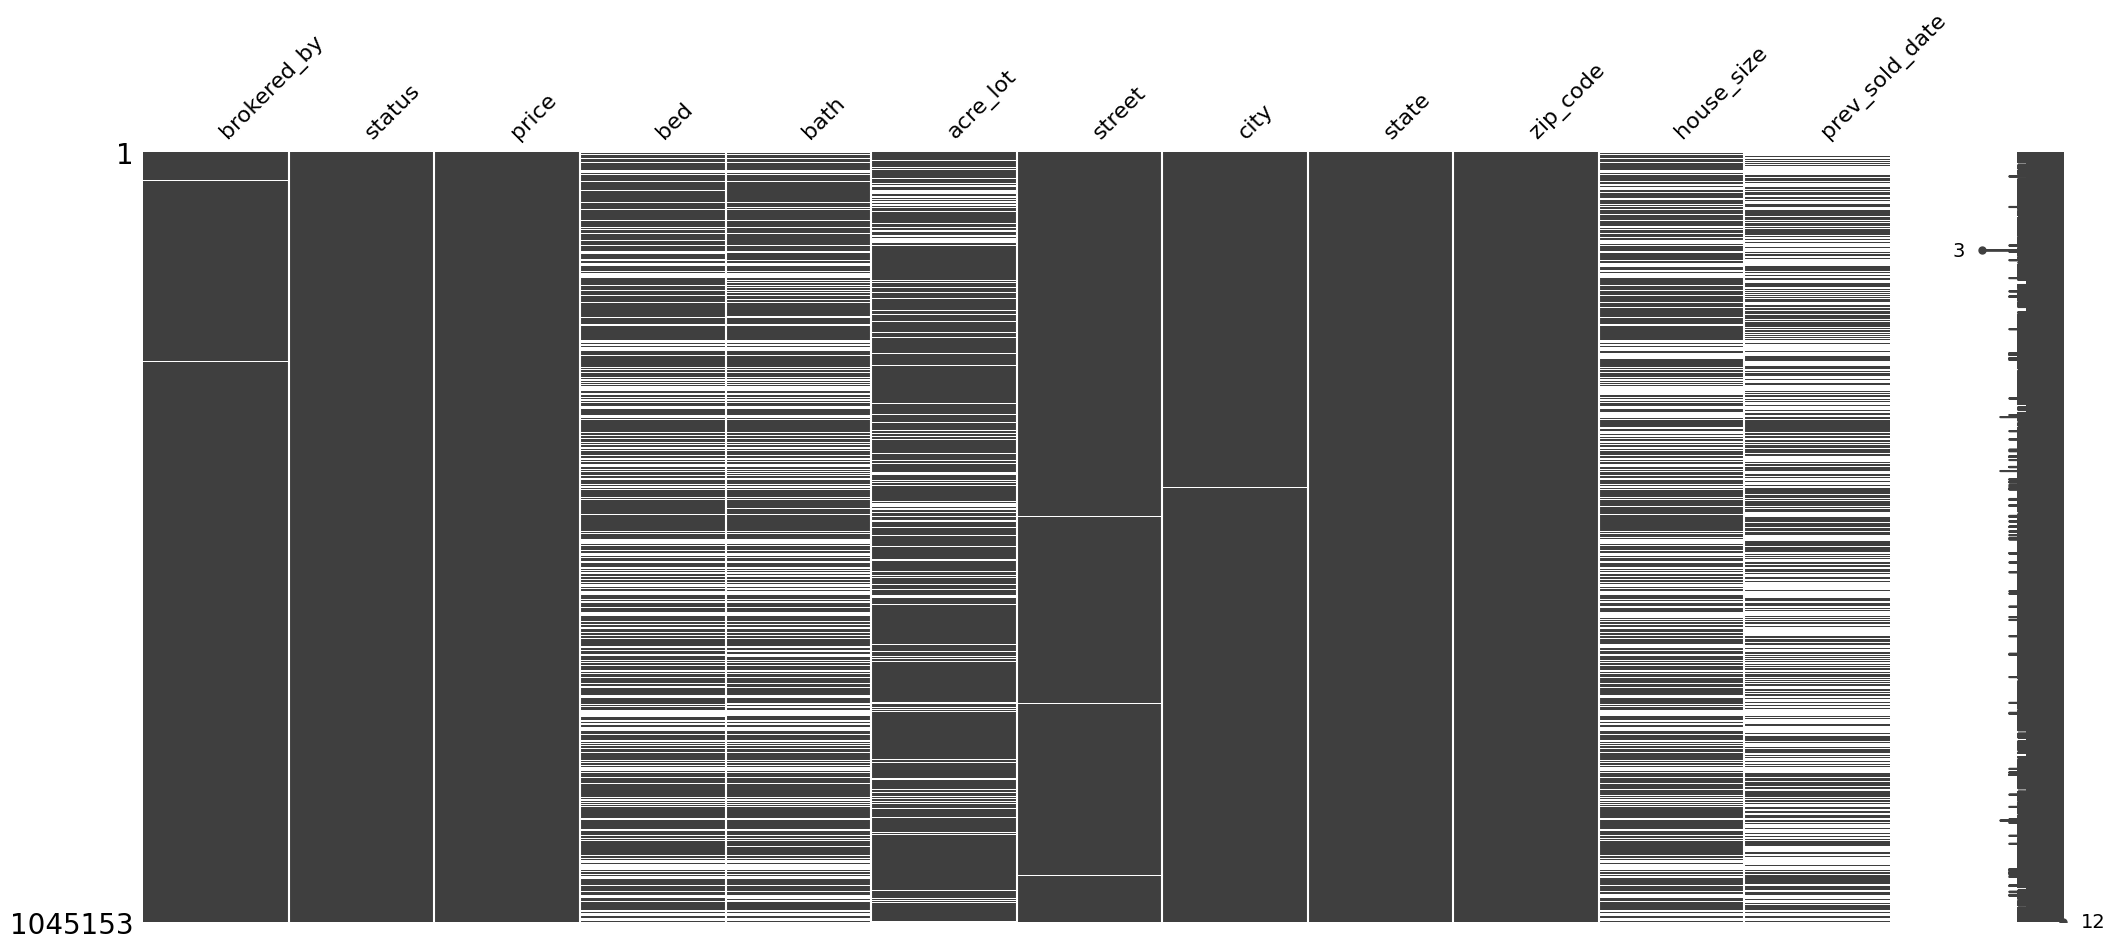

In [ ]:
#Visualize missing data (heatmap)
# Check if 'missingno' is installed, if not, install it
package_name = "missingno"
if importlib.util.find_spec(package_name) is None:
    print("⚠️ 'missingno' not found. Installing now...")
    subprocess.check_call(["pip", "install", package_name])

import missingno as msno  # Import after installation

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df_cleaned.toPandas()

# Visualizing missing data
print("📊 Missing Data Heatmap:")
msno.matrix(df_pandas)
plt.show()

In [ ]:
#Investigate properties with large acreage + missing key residential features
# Filter properties where acre_lot > 10
large_acreage_df = df_cleaned.filter(col("acre_lot") > 10).select("price", "house_size", "bed", "bath", "acre_lot", "status")

# Get a random sample of 10 rows
sample_size = 10
large_acreage_sample = large_acreage_df.sample(fraction=0.1).limit(sample_size)

# Show the sampled data
large_acreage_sample.show()

+---------+----------+----+----+--------+--------+
|    price|house_size| bed|bath|acre_lot|  status|
+---------+----------+----+----+--------+--------+
| 199900.0|      NULL|NULL|NULL|    32.5|for_sale|
| 365000.0|      NULL|NULL|NULL|   18.07|for_sale|
|1390000.0|      3112|   3|   5|   14.48|for_sale|
| 285000.0|      2268|   3|   3|   19.23|for_sale|
| 199900.0|      NULL|NULL|NULL|    16.5|for_sale|
|  61900.0|      NULL|NULL|NULL|   11.21|for_sale|
| 119000.0|      NULL|NULL|NULL|    26.0|for_sale|
|  60000.0|      NULL|NULL|NULL|    19.8|for_sale|
| 399000.0|      NULL|NULL|NULL|    90.0|for_sale|
| 695000.0|      1236|   3|   2|    23.0|for_sale|
+---------+----------+----+----+--------+--------+



These are likely non-residential listings. Removing these allows the focus to stay on the goal: Residential Home Price Prediction

In [ ]:
from pyspark.sql.functions import col

# Count rows before filtering
row_count_before = df_cleaned.count()

# Filter out rows with large acre_lot (>10) and missing residential details
df_cleaned = df_cleaned.filter(
    ~(
        (col("acre_lot").cast("double") > 10.0) &
        col("house_size").isNull() &
        col("bed").isNull() &
        col("bath").isNull()
    )
)

# Count rows after filtering and calculate removed rows
rows_removed = row_count_before - df_cleaned.count()

# Output result
print(f"✅ Non-residential properties removed. Rows removed: {rows_removed}")

✅ Non-residential properties removed. Rows removed: 58667


In [ ]:
# Show min & max values for key numerical columns
print("Checking min/max values for numerical features:")
df_cleaned.select(
    col("bed"),
    col("bath"),
    col("price"),
    col("acre_lot"),
    col("house_size")
).summary("min", "max").show()

Checking min/max values for numerical features:
+-------+---+----+-----------+--------+----------+
|summary|bed|bath|      price|acre_lot|house_size|
+-------+---+----+-----------+--------+----------+
|    min|  1|   1|        0.0|     0.0|         4|
|    max|473| 752|2.1474836E9|100000.0|   9842382|
+-------+---+----+-----------+--------+----------+



In [ ]:
# Remove listings where price is 0 or missing
df_cleaned = df_cleaned.filter(col("price") > 0)
# Print new row count
print(f"✅ Remaining Rows After Cleaning: {df_cleaned.count()}")

✅ Remaining Rows After Cleaning: 985402


In [ ]:
# Compute percentiles for price
quantiles = df_cleaned.approxQuantile("price", [0.90, 0.95, 0.99], 0.01)

# Print percentiles
print(f"📊 Price Percentiles:")
print(f"🔹 90th Percentile: ${quantiles[0]:,.2f}")
print(f"🔹 95th Percentile: ${quantiles[1]:,.2f}")
print(f"🔹 99th Percentile: ${quantiles[2]:,.2f}")

📊 Price Percentiles:
🔹 90th Percentile: $799,999.00
🔹 95th Percentile: $1,249,000.00
🔹 99th Percentile: $2,147,483,600.00


In [ ]:
# Remove rows where price is greater than the 95th percentile ($1.25M)
df_cleaned = df_cleaned.filter(col("price") <= 1250000)

# Print new row count
print(f"✅ Remaining Rows After Removing Prices Above $1.25M: {df_cleaned.count()}")

# Verify new price distribution
df_cleaned.describe(["price"]).show()

✅ Remaining Rows After Removing Prices Above $1.25M: 932686
+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|            932686|
|   mean|309323.40004209353|
| stddev|250164.34735656803|
|    min|               1.0|
|    max|         1250000.0|
+-------+------------------+



In [ ]:
# Count rows priced below $10,000
rows_below_10k = df_cleaned.filter(col("price") < 10000).count()
print(f"📊 Number of rows priced below $10,000: {rows_below_10k}")

# Show a sample of rows priced below $10,000
print("🔍 Sample of rows priced below $10,000:")
df_cleaned.filter(col("price") < 10000).show(10)  # Show 10 sample rows

📊 Number of rows priced below $10,000: 11690
🔍 Sample of rows priced below $10,000:
+-----------+--------+------+----+----+--------+-------+-----------+-------------+--------+----------+--------------+
|brokered_by|  status| price| bed|bath|acre_lot| street|       city|        state|zip_code|house_size|prev_sold_date|
+-----------+--------+------+----+----+--------+-------+-----------+-------------+--------+----------+--------------+
|        570|for_sale|9900.0|NULL|NULL|    0.67|1858270|    Florida|Massachusetts|    1247|      NULL|          NULL|
|      23538|for_sale|9500.0|NULL|NULL|    0.28|1971301|     Becket|Massachusetts|    1223|      NULL|          NULL|
|      22696|for_sale|7900.0|NULL|NULL|    0.31|1859588|Hubbardston|Massachusetts|    1452|      NULL|          NULL|
|      38156|for_sale|   1.0|NULL|NULL|    0.71|1335773|    Waltham|Massachusetts|    2453|      NULL|          NULL|
|      31977|for_sale|   1.0|NULL|NULL|     9.4|1966635|    Duxbury|Massachusetts|    2332

In [ ]:
# Remove homes priced below $10,000 (likely invalid)
df_cleaned = df_cleaned.filter(col("price") >= 10000)

# Print new row count
print(f"✅ Remaining Rows After Removing Prices Below $10K: {df_cleaned.count()}")

# Verify new price distribution
df_cleaned.describe(["price"]).show()

✅ Remaining Rows After Removing Prices Below $10K: 920996
+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           920996|
|   mean|313170.8356775274|
| stddev| 249390.089488608|
|    min|          10000.0|
|    max|        1250000.0|
+-------+-----------------+



In [ ]:
# Compute percentiles for acre_lot
acre_quantiles = df_cleaned.approxQuantile("acre_lot", [0.90, 0.95, 0.99], 0.01)

# Print percentiles
print(f"📊 Acre Lot Size Percentiles:")
print(f"🔹 90th Percentile: {acre_quantiles[0]:,.2f} acres")
print(f"🔹 95th Percentile: {acre_quantiles[1]:,.2f} acres")
print(f"🔹 99th Percentile: {acre_quantiles[2]:,.2f} acres")

📊 Acre Lot Size Percentiles:
🔹 90th Percentile: 3.02 acres
🔹 95th Percentile: 5.58 acres
🔹 99th Percentile: 100,000.00 acres


In [ ]:
# Remove homes with more than 5.15 acres
df_cleaned = df_cleaned.filter(col("acre_lot") <= 5.15)

# Print new row count
print(f"✅ Remaining Rows After Removing Acre Lots Above 5.15 Acres: {df_cleaned.count()}")

# Verify new lot size distribution
df_cleaned.describe(["acre_lot"]).show()


✅ Remaining Rows After Removing Acre Lots Above 5.15 Acres: 723246
+-------+------------------+
|summary|          acre_lot|
+-------+------------------+
|  count|            723246|
|   mean|0.7070235438564351|
| stddev|0.9895188196749646|
|    min|               0.0|
|    max|              5.15|
+-------+------------------+



In [ ]:
# Remove homes with less than 400 sqft and greater than 10,000 sqft
df_cleaned = df_cleaned.filter((col("house_size") >= 400) & (col("house_size") <= 10000))

# Print new row count
print(f"✅ Remaining Rows After Removing Homes Under 400 sqft: {df_cleaned.count()}")

# Verify new house size distribution
df_cleaned.describe(["house_size"]).show()

✅ Remaining Rows After Removing Homes Under 400 sqft: 476312
+-------+-----------------+
|summary|       house_size|
+-------+-----------------+
|  count|           476312|
|   mean|2013.738967315541|
| stddev|949.5446265324825|
|    min|              400|
|    max|            10000|
+-------+-----------------+



In [ ]:
# Remove unrealistic bed, bath
df_cleaned = df_cleaned.filter((col("bed") <= 10) & (col("bath") <= 10))

In [ ]:
# Show summary statistics for key numeric columns
df_cleaned.describe(["price", "bed", "bath", "house_size", "acre_lot"]).show()
# Print new row count
print(f"✅ Remaining Rows After Cleaning: {df_cleaned.count()}")

+-------+-----------------+------------------+-----------------+------------------+------------------+
|summary|            price|               bed|             bath|        house_size|          acre_lot|
+-------+-----------------+------------------+-----------------+------------------+------------------+
|  count|           469530|            469530|           469530|            469530|            469530|
|   mean|360866.4950141631|3.3522394735160694| 2.42713990586331|2003.8620045577493|0.5182536579132114|
| stddev|230042.2776794609|0.9919834513822542|1.007294514892727| 929.7161706445692|0.8022070600803747|
|    min|          10000.0|                 1|                1|               400|               0.0|
|    max|        1250000.0|                10|               10|             10000|              5.15|
+-------+-----------------+------------------+-----------------+------------------+------------------+

✅ Remaining Rows After Cleaning: 469530


In [ ]:
# Check for NULL
df_cleaned.filter(
    col("bed").isNull() & col("bath").isNull() & col("house_size").isNull()
).count()

0

In [ ]:
from pyspark.sql.functions import lpad
# Convert zip_code to a string and pad with leading zeros where applicable
df_cleaned = df_cleaned.withColumn("zip_code", lpad(col("zip_code").cast("string"), 5, "0"))

# Print unique zip codes to verify the fix
df_cleaned.select("zip_code").distinct().show(5)

+--------+
|zip_code|
+--------+
|   12529|
|   03442|
|   02053|
|   02090|
|   03904|
+--------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import substring

# Extract the first 3 digits of zip_code to create zip_region
df_cleaned = df_cleaned.withColumn("zip_region", substring(col("zip_code").cast("string"), 1, 3))

# Verify zip_region was created successfully
df_cleaned.select("zip_region").distinct().show(5)

# Show first 10 rows with zip_code and zip_region to verify correctness
df_cleaned.select("zip_region", "city", "price", "bed", "bath", "house_size").show(10, truncate=False)

+----------+
|zip_region|
+----------+
|       125|
|       124|
|       030|
|       088|
|       101|
+----------+
only showing top 5 rows

+----------+------+--------+---+----+----------+
|zip_region|city  |price   |bed|bath|house_size|
+----------+------+--------+---+----+----------+
|010       |Agawam|180000.0|2  |1   |676       |
|010       |Agawam|239900.0|3  |1   |1196      |
|010       |Agawam|525000.0|3  |3   |2314      |
|010       |Agawam|289900.0|3  |2   |1276      |
|010       |Agawam|275000.0|4  |2   |1732      |
|010       |Agawam|335000.0|6  |2   |1800      |
|010       |Agawam|384900.0|3  |2   |1476      |
|010       |Agawam|779900.0|4  |3   |2910      |
|010       |Agawam|199999.0|3  |2   |1968      |
|010       |Pelham|419000.0|4  |2   |1607      |
+----------+------+--------+---+----+----------+
only showing top 10 rows



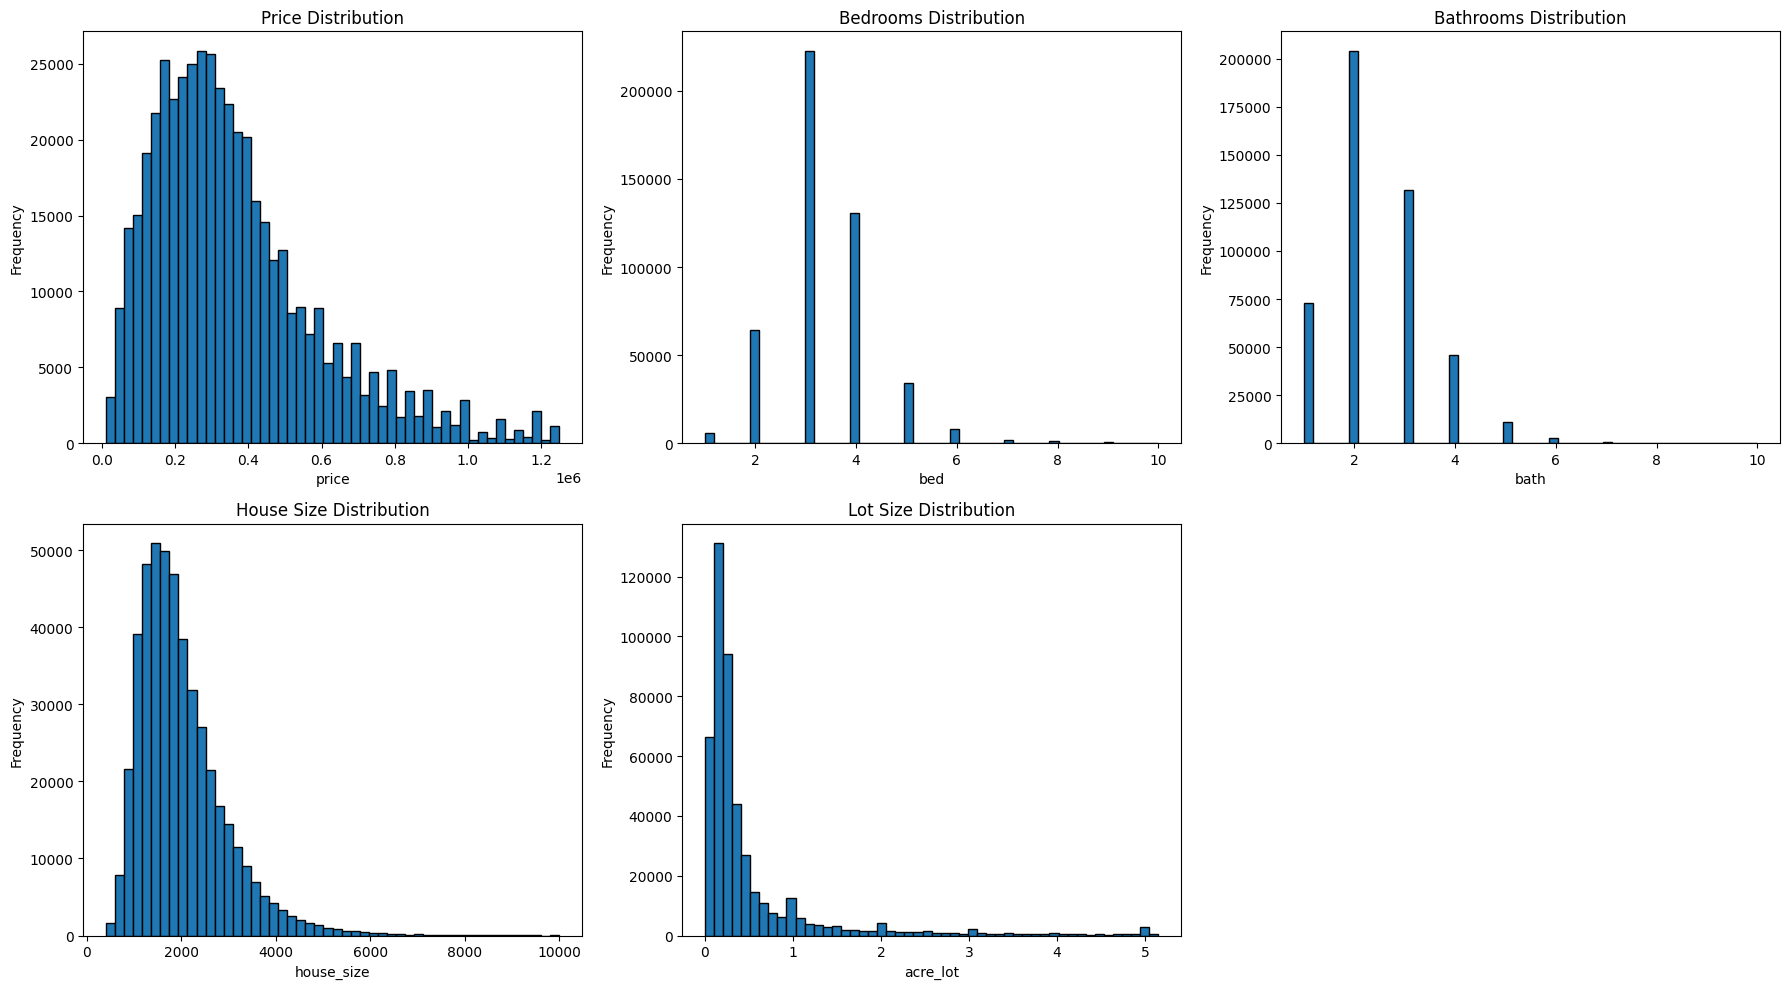

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas for visualization
df_pd = df_cleaned.select("price", "bed", "bath", "house_size", "acre_lot").toPandas()

# Create histograms
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Define features and titles
features = ["price", "bed", "bath", "house_size", "acre_lot"]
titles = ["Price Distribution", "Bedrooms Distribution", "Bathrooms Distribution", "House Size Distribution", "Lot Size Distribution"]

# Plot each distribution
for i, feature in enumerate(features):
    ax = axes[i // 3, i % 3]  # Determine subplot position
    ax.hist(df_pd[feature], bins=50, edgecolor='black')
    ax.set_title(titles[i])
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

# Remove empty subplot
fig.delaxes(axes[1, 2])

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import log1p

# Apply log transformation to acre_lot, house_size, & price
df_cleaned = df_cleaned.withColumn("log_acre_lot", log1p("acre_lot"))
df_cleaned = df_cleaned.withColumn("log_house_size", log1p("house_size"))
df_cleaned = df_cleaned.withColumn("log_price", log1p("price"))

# Confirm log_columns
df_cleaned.select("house_size", "log_house_size").show(5)
df_cleaned.select("acre_lot", "log_acre_lot").show(5)
df_cleaned.select("price", "log_price").show(5)

+----------+-----------------+
|house_size|   log_house_size|
+----------+-----------------+
|       676|6.517671272912275|
|      1196|7.087573705557973|
|      2314|7.747164966520335|
|      1276|7.152268856032539|
|      1732|7.457609289715606|
+----------+-----------------+
only showing top 5 rows

+--------+-------------------+
|acre_lot|       log_acre_lot|
+--------+-------------------+
|    0.34|   0.29266961396282|
|    0.46| 0.3784364357202451|
|    0.45|0.37156355643248307|
|    0.36| 0.3074846997479606|
|    0.11|0.10436001532424277|
+--------+-------------------+
only showing top 5 rows

+--------+------------------+
|   price|         log_price|
+--------+------------------+
|180000.0|12.100717685412471|
|239900.0|  12.3879816172226|
|525000.0|13.171155446333852|
|289900.0| 12.57729476436913|
|275000.0|12.524530013005734|
+--------+------------------+
only showing top 5 rows



In [ ]:
# Index categorical columns
zip_indexer = StringIndexer(inputCol="zip_region", outputCol="zip_indexed", handleInvalid="keep")

# Transform using df_cleaned
df_cleaned = zip_indexer.fit(df_cleaned).transform(df_cleaned).drop("zip_region")

# Verify transformation
df_cleaned.select("zip_indexed").show(5)

+-----------+
|zip_indexed|
+-----------+
|      380.0|
|      380.0|
|      380.0|
|      380.0|
|      380.0|
+-----------+
only showing top 5 rows



In [ ]:
# Add to first cell
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import when, log, col

# Replace zero or negative acre_lot values explicitly with 0.01, then log-transform
df_cleaned = df_cleaned.withColumn(
    "acre_lot",
    when(col("acre_lot") <= 0, 0.01).otherwise(col("acre_lot"))
)

# Create logged columns clearly and explicitly
df_logged = df_cleaned.withColumn("log_price", log(col("price"))) \
                      .withColumn("log_house_size", log(col("house_size"))) \
                      .withColumn("log_acre_lot", log(col("acre_lot")))



In [ ]:
from pyspark.sql.functions import col, isnan, when, count

cols_to_check = ["log_price", "log_house_size", "log_acre_lot", "bed", "bath"]

df_logged.select([
    count(when(
        col(c).isNull() | isnan(col(c)) | col(c).isin(float('inf'), float('-inf')),
        c
    )).alias(c + "_problem_values")
    for c in cols_to_check
]).show()

+------------------------+-----------------------------+---------------------------+------------------+-------------------+
|log_price_problem_values|log_house_size_problem_values|log_acre_lot_problem_values|bed_problem_values|bath_problem_values|
+------------------------+-----------------------------+---------------------------+------------------+-------------------+
|                       0|                            0|                          0|                 0|                  0|
+------------------------+-----------------------------+---------------------------+------------------+-------------------+



In [ ]:
# Assemble these logged features into a vector
assembler = VectorAssembler(
    inputCols=["log_house_size", "log_acre_lot", "bed","bath", "zip_indexed"],
    outputCol="features"
)

df_logged = assembler.transform(df_logged)

In [ ]:
# Show the input columns used in the VectorAssembler
print("✅ Columns used in 'features':")
print(assembler.getInputCols())


✅ Columns used in 'features':
['log_house_size', 'log_acre_lot', 'bed', 'bath', 'zip_indexed']


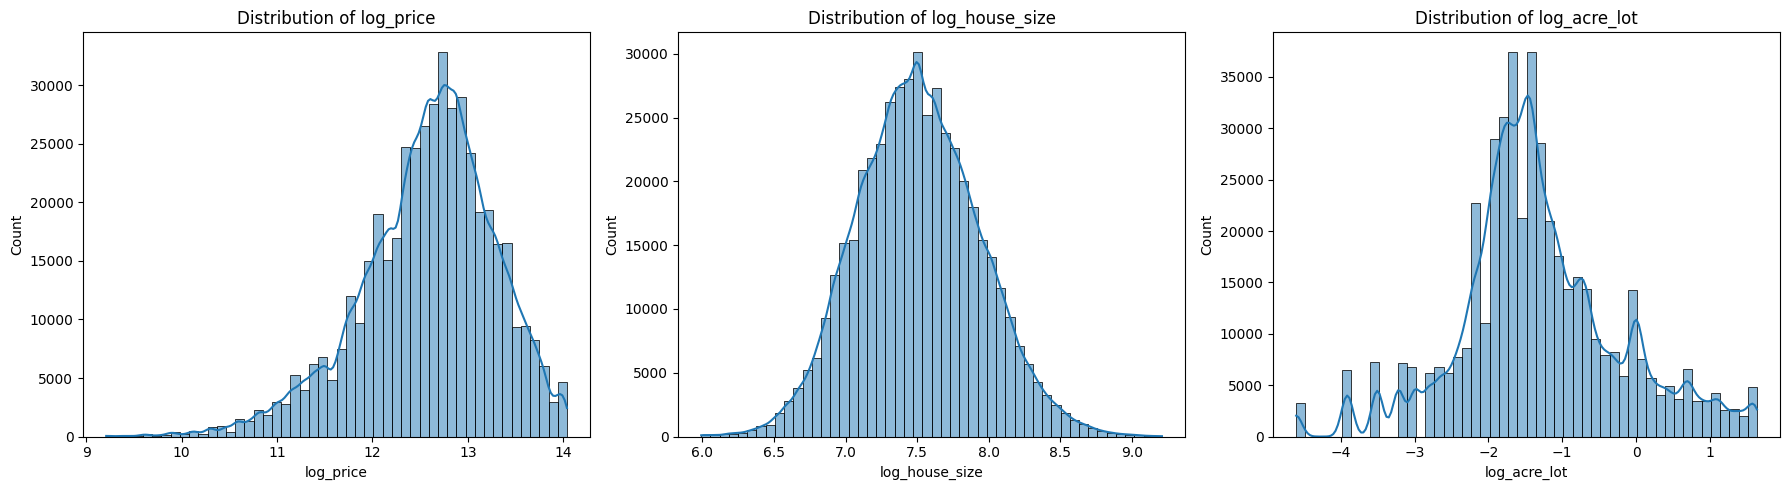

In [ ]:
# Select columns for visualization
df_viz = df_logged.select("log_price", "log_house_size", "log_acre_lot")

# Convert to Pandas DataFrame for visualization
df_pd = df_viz.toPandas()

# Plot distributions of log-transformed variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_pd["log_price"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of log_price")

sns.histplot(df_pd["log_house_size"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of log_house_size")

sns.histplot(df_pd["log_acre_lot"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Distribution of log_acre_lot")

plt.tight_layout()
plt.show()

The distributions of the log-transformed variables (log_price, log_house_size, log_acre_lot) are now more symmetric and approximately normal, reducing the effect of outliers. log_price and log_house_size exhibit clear bell-shaped curves, indicating a stable distribution suitable for modeling. However, log_acre_lot shows some left-skewness and a broader distribution, suggesting more variability and potential outliers still present.

In [ ]:
# Safe split into train/test again clearly
train_data, test_data = df_logged.randomSplit([0.8, 0.2], seed=42)

# Confirm the split explicitly
print(f"✅ Training Data Row Count: {train_data.count()}")
print(f"✅ Test Data Row Count: {test_data.count()}")


✅ Training Data Row Count: 375754
✅ Test Data Row Count: 93776


In [ ]:
# KS Test: Compare Train vs. Test Distributions of log_price
from scipy.stats import ks_2samp

# Extract log_price from train and test sets
train_prices = train_data.select("log_price").toPandas()["log_price"]
test_prices = test_data.select("log_price").toPandas()["log_price"]

# Run the KS test
ks_stat, p_value = ks_2samp(train_prices, test_prices)

# Display results
print("📊 KS-Test Results (Train vs. Test log_price)")
print(f"KS Statistic: {ks_stat:.4f}, P-Value: {p_value:.4f}")

if p_value > 0.05:
    print("✅ No significant difference between train and test distributions (p > 0.05).")
else:
    print("⚠️ Significant difference detected (p < 0.05), consider re-splitting.")


📊 KS-Test Results (Train vs. Test log_price)
KS Statistic: 0.0026, P-Value: 0.6859
✅ No significant difference between train and test distributions (p > 0.05).


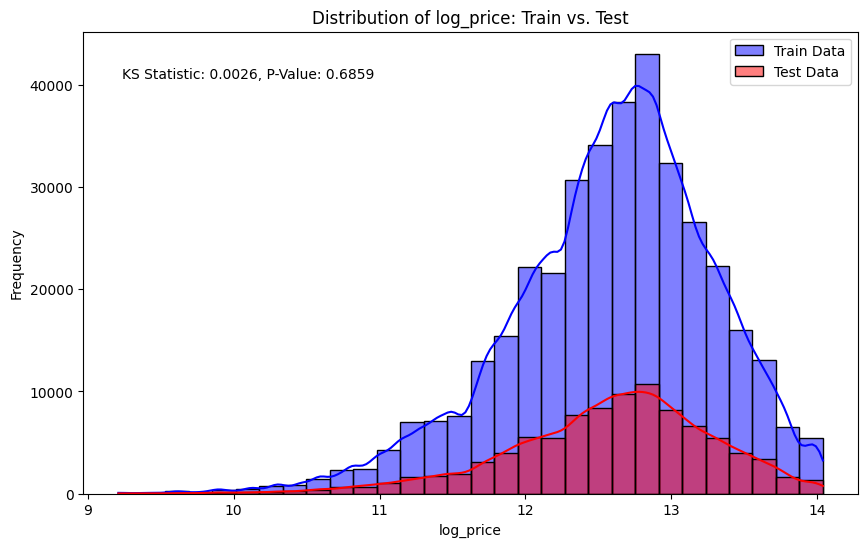

In [ ]:
# Visualize KS Test: Compare Train vs. Test Distributions of log_price
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Extract log_price from train and test sets
train_prices = train_data.select("log_price").toPandas()["log_price"]
test_prices = test_data.select("log_price").toPandas()["log_price"]

# Calculate the KS statistic and p-value
ks_stat, p_value = ks_2samp(train_prices, test_prices)

# Create histograms for train and test distributions
plt.figure(figsize=(10, 6))
sns.histplot(train_prices, label="Train Data", kde=True, color="blue", alpha=0.5, bins=30)
sns.histplot(test_prices, label="Test Data", kde=True, color="red", alpha=0.5, bins=30)

# Add title and labels
plt.title("Distribution of log_price: Train vs. Test")
plt.xlabel("log_price")
plt.ylabel("Frequency")

# Add KS test results to the plot
plt.text(0.05, 0.9, f"KS Statistic: {ks_stat:.4f}, P-Value: {p_value:.4f}", transform=plt.gca().transAxes)

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Add to first cell
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create and fit the linear regression model
lr = LinearRegression(featuresCol='features', labelCol='log_price')
lr_model = lr.fit(train_data)

# Make predictions on test data
predictions = lr_model.transform(test_data)

# Evaluate model performance using RMSE
evaluator = RegressionEvaluator(
    labelCol="log_price", predictionCol="prediction", metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
print(f"✅ RMSE on test data: {rmse:.4f}")

# Print R² as well
r2_evaluator = RegressionEvaluator(
    labelCol="log_price", predictionCol="prediction", metricName="r2"
)

r2 = r2_evaluator.evaluate(predictions)
print(f"✅ R² on test data: {r2:.4f}")

✅ RMSE on test data: 0.5176
✅ R² on test data: 0.4580


The linear regression model results:

RMSE: 0.5176

Indicates the average prediction error is approximately ±0.52 in predicting log_price.

This shows moderate prediction accuracy.

R²: 0.4580 (about 45.8%)

Indicates the model explains approximately 45.8% of the variance in your log-transformed house prices.

There is room for improvement.



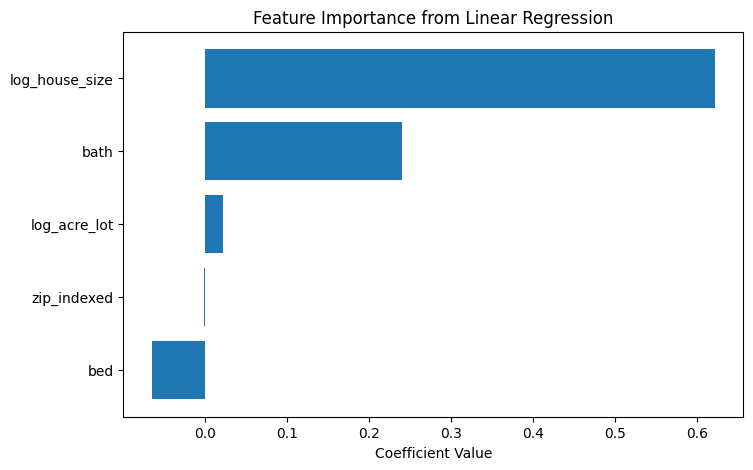

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract coefficients from the linear regression model
feature_importance = lr_model.coefficients.toArray()

# Feature names (exact order as VectorAssembler inputCols)
feature_names = ["log_house_size", "log_acre_lot", "bed", "bath", "zip_indexed"]

# Create a Pandas DataFrame for clear visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

# Plot the feature importance clearly
plt.figure(figsize=(8, 5))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel("Coefficient Value")
plt.title("Feature Importance from Linear Regression")
plt.gca().invert_yaxis()
plt.show()


Removing zip_indexed From Linear Model to avoid misleading results, since linear regression treats indexed zip codes as numeric and assumes an order that doesn't exist. Excluding this variable will improve model validity and interpretability.

In [ ]:
from pyspark.sql.functions import exp, col

# Convert log_price and predictions back to dollars explicitly
predictions_dollars = predictions.withColumn("actual_price", exp(col("log_price"))) \
                                 .withColumn("predicted_price", exp(col("prediction"))) \
                                 .withColumn("error_dollars", col("predicted_price") - col("actual_price"))

# Display sample predictions explicitly
predictions_dollars.select(
    "actual_price", "predicted_price", "error_dollars"
).show(10, truncate=False)

from pyspark.sql.functions import abs, mean

predictions_dollars.select(mean(abs("error_dollars")).alias("avg_abs_error_dollars")).show()



+------------------+------------------+-------------------+
|actual_price      |predicted_price   |error_dollars      |
+------------------+------------------+-------------------+
|299996.0000000001 |137367.31350125815|-162628.68649874197|
|359999.99999999994|345070.3124184222 |-14929.687581577746|
|519997.99999999977|344592.8057610295 |-175405.1942389703 |
|679899.9999999995 |578375.3418223999 |-101524.65817759966|
|379000.00000000023|233759.97297177138|-145240.02702822885|
|499900.0000000004 |288739.0820148235 |-211160.9179851769 |
|499000.0000000004 |242171.30240653077|-256828.69759346964|
|172799.99999999988|284643.59956018365|111843.59956018376 |
|449900.00000000006|488100.2683142704 |38200.26831427036  |
|149999.99999999994|112523.25962057107|-37476.74037942887 |
+------------------+------------------+-------------------+
only showing top 10 rows

+---------------------+
|avg_abs_error_dollars|
+---------------------+
|   120706.55689448715|
+---------------------+



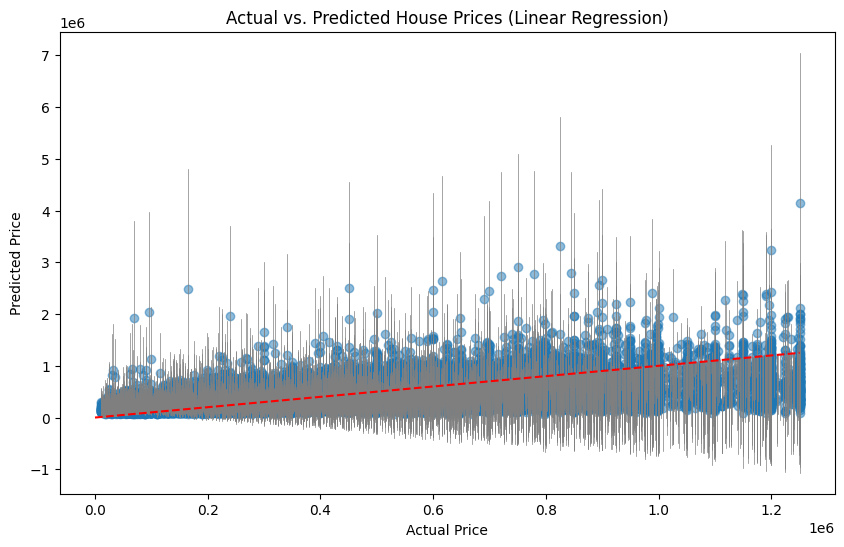

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import exp

# Visualize actual vs. predicted prices with error bars
prediction_pd = predictions_dollars.select("actual_price", "predicted_price", "error_dollars").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(prediction_pd["actual_price"], prediction_pd["predicted_price"], alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted House Prices (Linear Regression)")

# Add error bars
for i in range(len(prediction_pd)):
    plt.plot([prediction_pd["actual_price"][i], prediction_pd["actual_price"][i]],
             [prediction_pd["predicted_price"][i] - prediction_pd["error_dollars"][i], prediction_pd["predicted_price"][i] + prediction_pd["error_dollars"][i]],
             color="gray", linewidth=0.5)

plt.plot([0, prediction_pd["actual_price"].max()], [0, prediction_pd["actual_price"].max()], color="red", linestyle="--")

plt.show()


Moving on to Gradient Boosted Trees (GBT) for regression because it handles nonlinear relationships and feature interactions better than the linear models used thus far:

Linear Regression (Spark)

Random Forest (tested in earlier Pandas notebook)

It is robust to outliers and naturally supports feature importance

It can improve accuracy over simpler models through iterative error correction (i.e., Each new model (or tree) is trained to correct the errors made by the previous model.)

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create GBT Regressor (predicting log_price)
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="log_price",
    maxIter=50,
    maxBins=800  # must be >= number of zip_indexed categories
)
# Train the model
gbt_model = gbt.fit(train_data)

# Predict on test data
gbt_predictions = gbt_model.transform(test_data)

# Evaluate with RMSE and R²
evaluator_rmse = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(gbt_predictions)
r2 = evaluator_r2.evaluate(gbt_predictions)

# Show results
print(f"✅ GBT RMSE on test data: {rmse:.4f}")
print(f"✅ GBT R² on test data: {r2:.4f}")


✅ GBT RMSE on test data: 0.3821
✅ GBT R² on test data: 0.7046


GBT model significantly outperforms the linear model:

RMSE: ↓ from 0.5176 → 0.3821

R²: ↑ from 0.4580 → 0.7046
Likely due to zip_region being categorical

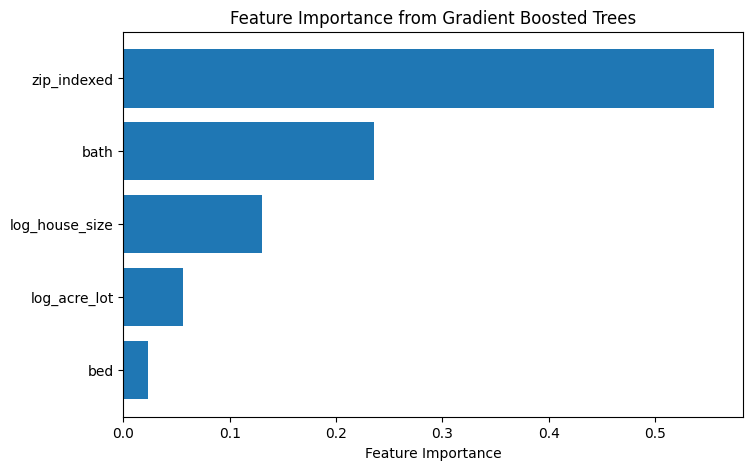

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Extract feature importances from the GBT model
feature_importances_gbt = gbt_model.featureImportances.toArray()

# Feature names (exact order as VectorAssembler inputCols)
feature_names = ["log_house_size", "log_acre_lot", "bed", "bath", "zip_indexed"]

# Create a Pandas DataFrame for clear visualization
importance_df_gbt = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances_gbt
}).sort_values(by='importance', ascending=False)


# Plot the feature importance clearly
plt.figure(figsize=(8, 5))
plt.barh(importance_df_gbt['feature'], importance_df_gbt['importance'])
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Gradient Boosted Trees")
plt.gca().invert_yaxis()
plt.show()

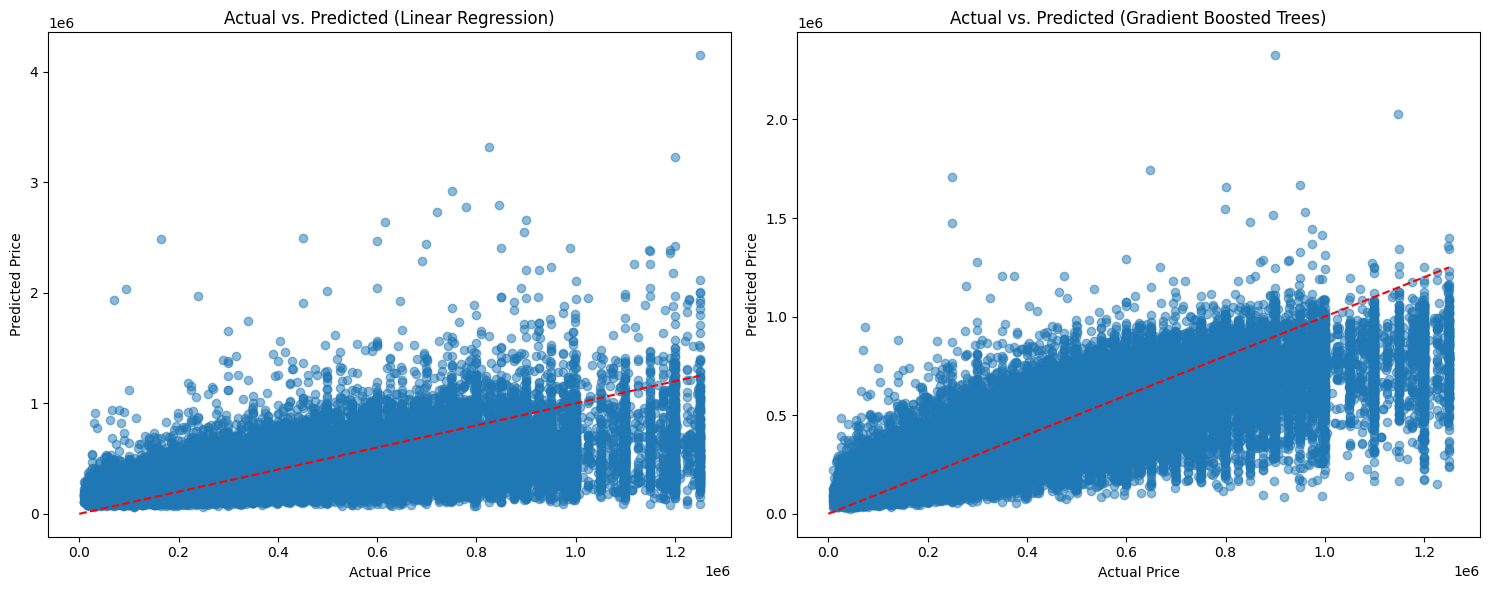

In [ ]:
#Plot Actual vs Predicted price for Linear and GBT to compare
# Create a figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Linear Regression Plot (Left side)
axes[0].scatter(prediction_pd["actual_price"], prediction_pd["predicted_price"], alpha=0.5)
axes[0].set_xlabel("Actual Price")
axes[0].set_ylabel("Predicted Price")
axes[0].set_title("Actual vs. Predicted (Linear Regression)")
axes[0].plot([0, prediction_pd["actual_price"].max()], [0, prediction_pd["actual_price"].max()], color="red", linestyle="--")

# Gradient Boosted Trees Plot (Right side)
gbt_predictions_dollars = gbt_predictions.withColumn("actual_price", exp(col("log_price"))) \
                                         .withColumn("predicted_price", exp(col("prediction"))) \
                                         .withColumn("error_dollars", col("predicted_price") - col("actual_price"))

gbt_prediction_pd = gbt_predictions_dollars.select("actual_price", "predicted_price", "error_dollars").toPandas()


axes[1].scatter(gbt_prediction_pd["actual_price"], gbt_prediction_pd["predicted_price"], alpha=0.5)
axes[1].set_xlabel("Actual Price")
axes[1].set_ylabel("Predicted Price")
axes[1].set_title("Actual vs. Predicted (Gradient Boosted Trees)")
axes[1].plot([0, gbt_prediction_pd["actual_price"].max()], [0, gbt_prediction_pd["actual_price"].max()], color="red", linestyle="--")


# Adjust layout and display the plots
plt.tight_layout()
plt.show()


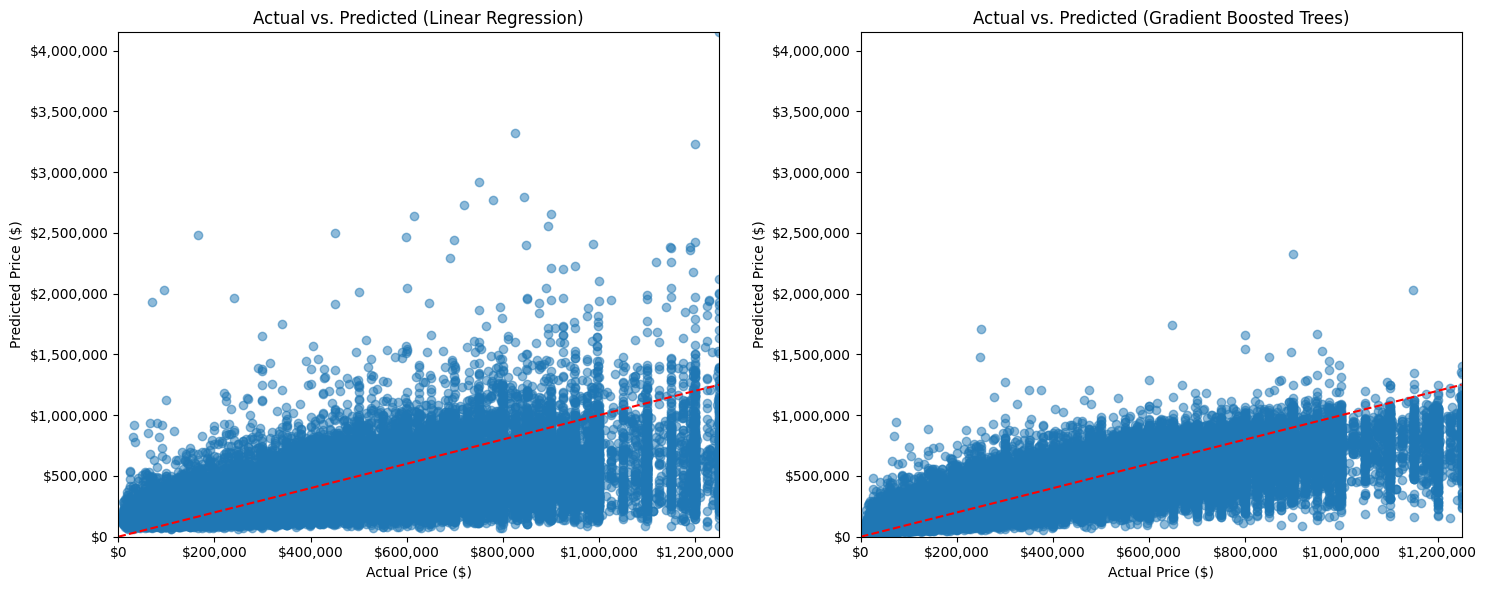

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Determine shared axis limits
x_max = max(prediction_pd["actual_price"].max(), gbt_prediction_pd["actual_price"].max())
y_max = max(prediction_pd["predicted_price"].max(), gbt_prediction_pd["predicted_price"].max())

# Create side-by-side plots with same axis limits
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Linear Regression Plot (Left)
axes[0].scatter(prediction_pd["actual_price"], prediction_pd["predicted_price"], alpha=0.5)
axes[0].set_xlabel("Actual Price ($)")
axes[0].set_ylabel("Predicted Price ($)")
axes[0].set_title("Actual vs. Predicted (Linear Regression)")
axes[0].plot([0, x_max], [0, x_max], color="red", linestyle="--")
axes[0].set_xlim(0, x_max)
axes[0].set_ylim(0, y_max)
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
axes[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Gradient Boosted Trees Plot (Right)
axes[1].scatter(gbt_prediction_pd["actual_price"], gbt_prediction_pd["predicted_price"], alpha=0.5)
axes[1].set_xlabel("Actual Price ($)")
axes[1].set_ylabel("Predicted Price ($)")
axes[1].set_title("Actual vs. Predicted (Gradient Boosted Trees)")
axes[1].plot([0, x_max], [0, x_max], color="red", linestyle="--")
axes[1].set_xlim(0, x_max)
axes[1].set_ylim(0, y_max)
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
axes[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
plt.show()




In [ ]:
# Show the input columns used in the trained GBT model
print("Features used in model:", gbt_model.getFeaturesCol())
print("Input columns used to assemble features:", assembler.getInputCols())


Features used in model: features
Input columns used to assemble features: ['log_house_size', 'log_acre_lot', 'bed', 'bath', 'zip_indexed']


In [ ]:
# Extract feature importances
feature_importances = gbt_model.featureImportances.toArray()

# Match the exact order used in VectorAssembler
feature_names = ["log_house_size", "log_acre_lot", "bed", "bath", "zip_indexed"]

# Print feature importances clearly
print("\n📊 GBT Feature Importance Scores:")
for name, importance in zip(feature_names, feature_importances):
    print(f"{name}: {importance:.4f}")



📊 GBT Feature Importance Scores:
log_house_size: 0.1306
log_acre_lot: 0.0559
bed: 0.0226
bath: 0.2353
zip_indexed: 0.5555


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Add bed-to-bath ratio (avoiding division by zero)
df_logged = df_logged.withColumn("bed_to_bath_ratio", col("bed") / (col("bath") + 1))

# Drop existing 'features' column if it exists
df_logged = df_logged.drop("features")

# Define the new set of input features
feature_cols = ["bed_to_bath_ratio", "log_house_size", "log_acre_lot", "zip_indexed"]

# Assemble new features vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_engineered = assembler.transform(df_logged).select("features", "log_price", "bed_to_bath_ratio")

# Show a preview of the engineered data
print("✅ Added `bed_to_bath_ratio` and rebuilt `features`. Preview:")
df_engineered.show(5)


✅ Added `bed_to_bath_ratio` and rebuilt `features`. Preview:
+--------------------+------------------+------------------+
|            features|         log_price| bed_to_bath_ratio|
+--------------------+------------------+------------------+
|[1.0,6.5161930760...|12.100712129872347|               1.0|
|[1.5,7.0867379345...|12.387977448827787|               1.5|
|[0.75,7.746732907...| 13.17115354157376|              0.75|
|[1.0,7.1514854639...|12.577291314909747|               1.0|
|[1.33333333333333...|12.524526376648708|1.3333333333333333|
+--------------------+------------------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Split the newly engineered data
train_data, test_data = df_engineered.randomSplit([0.8, 0.2], seed=42)

# Train GBT model with updated features
gbt = GBTRegressor(featuresCol="features", labelCol="log_price", maxIter=50, maxBins=800)
gbt_model = gbt.fit(train_data)

# Predict and evaluate
predictions = gbt_model.transform(test_data)
rmse = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse").evaluate(predictions)
r2 = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2").evaluate(predictions)

print(f"✅ Updated GBT RMSE: {rmse:.4f}")
print(f"✅ Updated GBT R²: {r2:.4f}")

✅ Updated GBT RMSE: 0.3856
✅ Updated GBT R²: 0.6953


In [ ]:
# Extract GBT feature importances
importances = gbt_model.featureImportances.toArray()

# Define updated feature names (must match VectorAssembler inputCols)
feature_names = ["bed_to_bath_ratio", "log_house_size", "log_acre_lot", "zip_indexed"]

# Print feature importances clearly
print("\n📊 Updated GBT Feature Importance Scores:")
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")


📊 Updated GBT Feature Importance Scores:
bed_to_bath_ratio: 0.0653
log_house_size: 0.3080
log_acre_lot: 0.0477
zip_indexed: 0.5790


Feature	Importance Interpretation
zip_indexed	0.5790	📍 Still the strongest predictor — location dominates.

log_house_size	0.3080	🏠 Strong influence — larger homes predict higher prices.

bed_to_bath_ratio	0.0653	🚿🛏️ Low-to-moderate value — adds some signal, but overlaps with existing info.

log_acre_lot	0.0477	🌳 Least important — lot size adds minimal additional insight.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Drop old features column if it exists
df_logged = df_logged.drop("features")

# Rebuild features with the top 3 predictors
feature_cols = ["zip_indexed", "log_house_size", "bath"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create new engineered dataframe
df_engineered = assembler.transform(df_logged).select("features", "log_price")


In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Split
train_data, test_data = df_engineered.randomSplit([0.8, 0.2], seed=42)

# Train GBT model
gbt = GBTRegressor(featuresCol="features", labelCol="log_price", maxIter=50, maxBins=800)
gbt_model = gbt.fit(train_data)

# Predict
predictions = gbt_model.transform(test_data)

# Evaluate
rmse = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse").evaluate(predictions)
r2 = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2").evaluate(predictions)

print(f"✅ GBT RMSE (3 features): {rmse:.4f}")
print(f"✅ GBT R² (3 features): {r2:.4f}")


✅ GBT RMSE (3 features): 0.3977
✅ GBT R² (3 features): 0.6815


In [ ]:
# Print feature importances
importances = gbt_model.featureImportances.toArray()
feature_names = ["zip_indexed", "log_house_size", "bath"]

print("\n📊 GBT Feature Importance (zip_indexed, log_house_size, bath):")
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")



📊 GBT Feature Importance (zip_indexed, log_house_size, bath):
zip_indexed: 0.5454
log_house_size: 0.1583
bath: 0.2963


In [ ]:
# Feature set with 'bed' added back
# Drop old features column if it exists
df_logged = df_logged.drop("features")

# Define feature set with 'bed' added back
feature_cols = ["bed", "bath", "log_house_size", "log_acre_lot", "zip_indexed"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
# Create engineered dataframe
df_engineered = assembler.transform(df_logged).select("features", "log_price")

# Train/test split
train_data, test_data = df_engineered.randomSplit([0.8, 0.2], seed=42)

# Train GBT model
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="log_price",
    maxIter=70,
    maxDepth=7,
    maxBins=800,
    stepSize=0.05,
    seed=42
)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

# Convert back to dollar prices
gbt_predictions_actual = gbt_predictions.withColumn("actual_price", exp(col("log_price"))) \
                                        .withColumn("predicted_price", exp(col("prediction")))

# Evaluate RMSE in dollars
gbt_evaluator_actual = RegressionEvaluator(labelCol="actual_price", predictionCol="predicted_price", metricName="rmse")
gbt_rmse_actual = gbt_evaluator_actual.evaluate(gbt_predictions_actual)

# Evaluate R² in log scale
gbt_r2_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2")
gbt_r2 = gbt_r2_evaluator.evaluate(gbt_predictions)

# Print results
print(f"✅ GBT RMSE in Dollars (Adding Back Bed): ${gbt_rmse_actual:,.2f}")
print(f"📈 GBT R² (Adding Back Bed): {gbt_r2:.4f}")


✅ GBT RMSE in Dollars (Adding Back Bed): $130,029.94
📈 GBT R² (Adding Back Bed): 0.7076


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import exp, col

# Reuse evaluators
rmse_evaluator = RegressionEvaluator(labelCol="actual_price", predictionCol="predicted_price", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="actual_price", predictionCol="predicted_price", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2")

# Convert predictions to dollar scale (already done for test earlier)
# But ensure you have this for train as well:
train_predictions = gbt_model.transform(train_data)
train_predictions_actual = train_predictions.withColumn("actual_price", exp(col("log_price"))) \
                                            .withColumn("predicted_price", exp(col("prediction")))

# Evaluate test
test_rmse = rmse_evaluator.evaluate(gbt_predictions_actual)
test_mae = mae_evaluator.evaluate(gbt_predictions_actual)
test_r2 = r2_evaluator.evaluate(gbt_predictions)

# Evaluate train
train_rmse = rmse_evaluator.evaluate(train_predictions_actual)
train_mae = mae_evaluator.evaluate(train_predictions_actual)
train_r2 = r2_evaluator.evaluate(train_predictions)

# Print
print("📊 Gradient Boosting Regression Results:")
print(f"🔹 Train R²: {train_r2:.4f}")
print(f"🔹 Test R²: {test_r2:.4f}")
print(f"🔹 Train MAE: ${train_mae:,.2f}")
print(f"🔹 Test MAE: ${test_mae:,.2f}")
print(f"🔹 Train RMSE: ${train_rmse:,.2f}")
print(f"🔹 Test RMSE: ${test_rmse:,.2f}")


📊 Gradient Boosting Regression Results:
🔹 Train R²: 0.7465
🔹 Test R²: 0.7076
🔹 Train MAE: $80,347.01
🔹 Test MAE: $85,965.94
🔹 Train RMSE: $120,266.90
🔹 Test RMSE: $130,029.94


In [ ]:
from pyspark.sql.functions import col

# Compute the 99th percentile of log_price
percentile_99 = df_logged.approxQuantile("log_price", [0.99], 0.01)[0]

# Filter out the top 1% most expensive homes
df_filtered = df_logged.filter(col("log_price") < percentile_99)

# Confirm filtering
print(f"✅ Removed homes above {percentile_99:.2f} log price (~top 1%).")



✅ Removed homes above 14.04 log price (~top 1%).


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Drop old 'features' column if it exists
df_filtered = df_filtered.drop("features")

# Define top features (same as last good model)
feature_cols = ["bed", "bath", "log_house_size", "log_acre_lot", "zip_indexed"]

# Assemble new features vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_engineered_filtered = assembler.transform(df_filtered).select("features", "log_price")


In [ ]:
# Split the filtered dataset
train_data, test_data = df_engineered_filtered.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.ml.regression import GBTRegressor

# Define and train the GBT model
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="log_price",
    maxIter=70,
    maxDepth=7,
    maxBins=800,
    stepSize=0.05,
    seed=42
)

gbt_model = gbt.fit(train_data)

In [ ]:
from pyspark.sql.functions import exp, col

# Predict and convert to actual price
test_predictions = gbt_model.transform(test_data)
test_predictions_actual = test_predictions.withColumn("actual_price", exp(col("log_price"))) \
                                          .withColumn("predicted_price", exp(col("prediction")))

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Set up evaluators
rmse_evaluator = RegressionEvaluator(labelCol="actual_price", predictionCol="predicted_price", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="actual_price", predictionCol="predicted_price", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2")

# Evaluate test performance
test_rmse = rmse_evaluator.evaluate(test_predictions_actual)
test_mae = mae_evaluator.evaluate(test_predictions_actual)
test_r2 = r2_evaluator.evaluate(test_predictions)

# Print results
print("📊 GBT Results After Removing Top 1% of Prices:")
print(f"🔹 Test R²: {test_r2:.4f}")
print(f"🔹 Test MAE: ${test_mae:,.2f}")
print(f"🔹 Test RMSE: ${test_rmse:,.2f}")

📊 GBT Results After Removing Top 1% of Prices:
🔹 Test R²: 0.7072
🔹 Test MAE: $85,165.39
🔹 Test RMSE: $127,546.82


Removal of the top 1% of home prices slightly reduced prediction error (RMSE and MAE) while R² remained nearly unchanged.

High-end outliers did not heavily influence model performance, but their removal contributed to slightly more stable predictions.

The resulting model is cleaner and still performs well on unseen data.

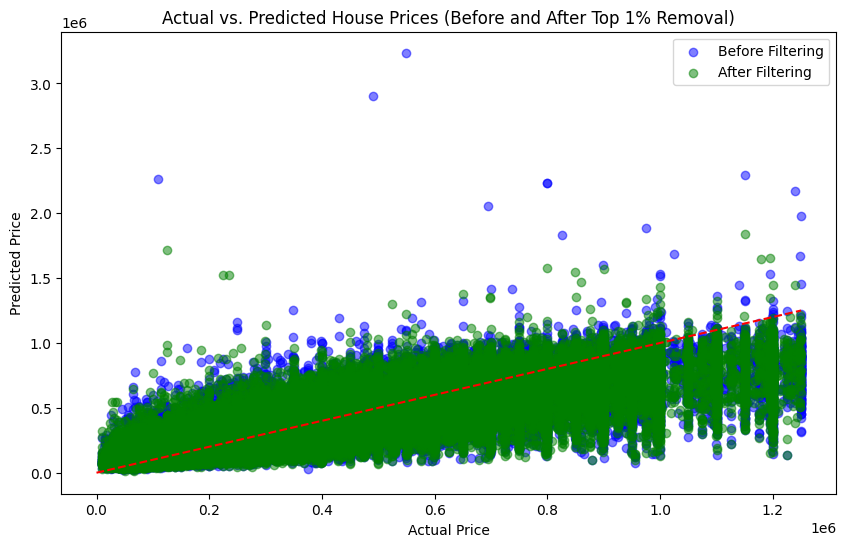

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import exp

# Convert predictions and actual prices to Pandas DataFrames
prediction_pd = gbt_predictions_actual.select("actual_price", "predicted_price").toPandas()
filtered_prediction_pd = test_predictions_actual.select("actual_price", "predicted_price").toPandas()


# Visualize actual vs. predicted prices (Before filtering)
plt.figure(figsize=(10, 6))
plt.scatter(prediction_pd["actual_price"], prediction_pd["predicted_price"], alpha=0.5, color="blue", label="Before Filtering")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted House Prices (Before and After Top 1% Removal)")
plt.plot([0, prediction_pd["actual_price"].max()], [0, prediction_pd["actual_price"].max()], color="red", linestyle="--")

# Visualize actual vs. predicted prices (After filtering)
plt.scatter(filtered_prediction_pd["actual_price"], filtered_prediction_pd["predicted_price"], alpha=0.5, color="green", label="After Filtering")


plt.legend()

plt.show()


In [ ]:
from pyspark.sql.functions import abs

mape_df = test_predictions_actual.withColumn(
    "abs_pct_error", abs((col("actual_price") - col("predicted_price")) / col("actual_price"))
)

mape = mape_df.selectExpr("avg(abs_pct_error) as mape").collect()[0]["mape"]
print(f"📊 MAPE: {mape:.2%}")


📊 MAPE: 30.58%


A 30.58% MAPE means the model is reasonably capturing price trends, but individual price estimates may vary widely.

For high-level analysis or trend prediction, this model is still useful.

For precise home valuation, performance should be improved (e.g., more features, regional models, or advanced techniques like XGBoost).

In [ ]:
# Select key columns and convert to Pandas
error_pd = test_predictions_actual.select("actual_price", "predicted_price").toPandas()


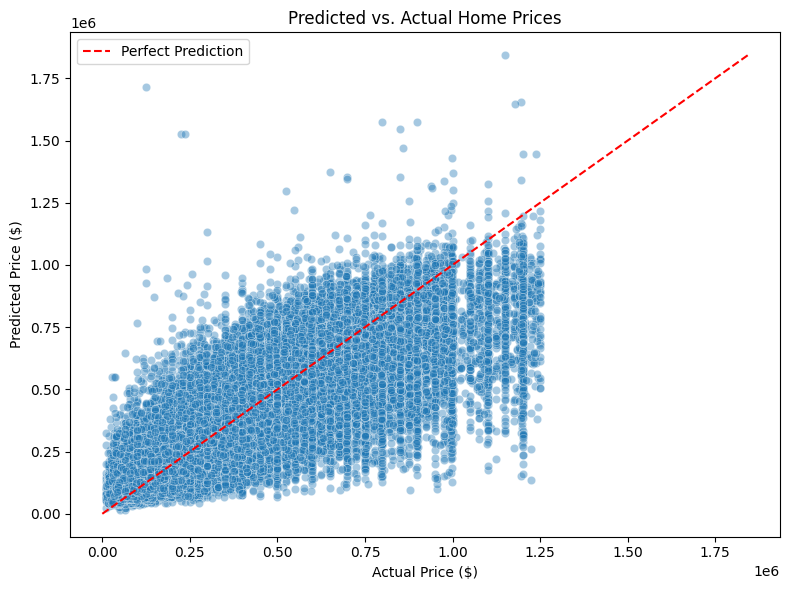

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=error_pd, x="actual_price", y="predicted_price", alpha=0.4)

# Add a 45-degree reference line
max_val = max(error_pd["actual_price"].max(), error_pd["predicted_price"].max())
plt.plot([0, max_val], [0, max_val], color="red", linestyle="--", label="Perfect Prediction")

plt.title("Predicted vs. Actual Home Prices")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
end_time = time.time()
elapsed = end_time - start_time
print(f"⏱️ Total Runtime: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

⏱️ Total Runtime: 1249.08 seconds (20.82 minutes)


The model generalizes well for mid-priced homes, but struggles as prices climb — a common issue in regression with heteroscedasticity (variance increases with target).

Even after removing the top 1%, high-priced homes are still harder to model — may require adding features like location type, luxury indicators, or separate modeling.

Ideas for future processing

Although the current Gradient Boosted Trees model performs well (R² ≈ 0.71), several steps can be taken to improve accuracy, interpretability, and real-world usability:

1. Enhance Location Features Beyond Zip Code
Zip code is the strongest predictor, but it's still a broad geographic grouping.

Incorporating city, neighborhood, school ratings, or proximity to amenities could better capture local pricing trends.

Use latitude/longitude for precise spatial modeling (e.g., via geohashing or clustering).

2. Refine House Size Representation
The model currently uses total square footage (log_house_size), but:

Splitting this into finished vs. unfinished sqft, or

Including lot size, garage sqft, number of floors, etc. could boost prediction power.

3. Handle High-End Homes Separately
The model underperforms at higher price points.

Solution: Train a separate model for luxury properties or use segmented modeling by price tiers.

4. Explore Advanced Models

GBTs are strong, but other algorithms could improve performance:

XGBoost or LightGBM (via PySpark or external integration)

Neural networks for deeper feature interactions

Ensemble methods combining multiple model types

5. Add Temporal Data (If Available)

Prices fluctuate over time. Including a year built, last sale date, or market conditions at time of sale would allow for time-aware predictions.

6. Improve Interpretability

Add confidence intervals or error bounds to give users a range of expected prices.

Consider using SHAP values for explainable AI to show users why a home’s prediction is what it is. An example SHAP explanation: “$200,000 base value + $50,000 for 2 bathrooms – $15,000 for small lot size = $235,000 prediction.”

7. Expand Data Sources

Supplement the dataset with external real estate APIs, like Zillow, Redfin, or census data for income, crime rate, etc.

Improve accuracy in underserved zip codes with more examples or upsampled data.



The current model is a strong foundation — it effectively predicts home prices based on user-specified inputs like beds, baths, square footage, and zip code. Moving forward, enriching the dataset and tailoring the modeling strategy to address outliers and spatial nuances will help turn this into a production-ready tool.